<h1> BGC Plots </h1>

In [1]:
#Script to create oxygen plots

import numpy as np
from tqdm import tqdm
import xarray as xr
import scipy.io as sio
import cmocean as cmocean
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath                  # to draw circle for map
import cartopy                                   # to make map
import cartopy.crs as ccrs               # for map projection
import cartopy.feature as cfeature           # to add land features to map
from datetime import date               # for saving figures with today
import matplotlib.animation as animation
from PIL import Image
import matplotlib.path as mpath
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [2]:
#Initializing settings for plots

###### UNIVERSAL PLOT PARAMETERS ######

#### FIGURE SIZE
fig_width  = 3   # inches
fig_height = 3   # inches

#### FONT SIZES
fontsize_large  = 8
fontsize_medium = 6
fontsize_small  = 4

#### MARKER AND LINE SIZES
markersize     = 0.25
axis_linewidth = 1
box_linewidth  = 0.5

#### PLOT COLORS
plot_facecolor          = '#E6F1F1'
overplot_label_color    = '#7B878F'
darker_label_color      = '#C9CCD4'
background_poster_color = '#14417C'
box_color               = '#FA5BBB'

##################################################################
######  Set up Southern Ocean Map  ###############################
##################################################################

def map_southern_ocean_axes_setup(
    ax:                    matplotlib.axes.Axes,
    fig:                   matplotlib.figure.Figure,
    max_latitude:          float = -30,
    add_gridlines:         bool  = True,
    color_land:            bool  = False,
    land_edgecolor:        str   = 'grey',
    land_facecolor:        str   = 'grey',
    fontsize:              float = 10,
    map_facecolor:         str   = 'white',
    coast_linewidth:       float = 0.3,
    gridlines_linewidth:   float = 0.5,
    girdlines_color:       str   = 'grey',
    gridlines_alpha:       float = 0.5,
    longitude_label_color: str   = 'grey',
    latitude_label_color:  str   = 'grey'
) -> None:
    """
    This function sets up the subplot so that it is a cartopy map of the Southern Ocean.
    returns void as the ax and figure objects are pointers not data.
    Args:
        ax  (matplotlib.axes.Axes):     The axis object to add the map to.
        fig (matplotlib.figure.Figure): The figure object for the figure in general.
        add_gridlines (bool):           Whether or not to add gridlines to the plot.
    """
    
    
    ### Limit the map to -40 degrees latitude and below.
    ax.set_extent([-180, 180, -90, max_latitude+0.6], ccrs.PlateCarree())  # set to -29.4 for map out to 30 degrees or -39.4 for map out to 40 degrees
   
    ### Tune the subplot layout
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)
    
    ### Make the background of the plot white
    ax.set_facecolor(map_facecolor)

    ### Make SO plot boundary a circle
    def plot_circle_boundary() -> None:
        """
        Make SO plot boundary a circle.
        Compute a circle in axes coordinates, which we can use as a boundary for the map.
        We can pan/zoom as much as we like - the boundary will be permanently circular.
        """
        theta  = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5  ## could use 0.45 here, as Simon Thomas did
        verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform = ax.transAxes)

    plot_circle_boundary()


    ### Add gridlines (if True)
    if add_gridlines:
        ax.gridlines(color = girdlines_color, alpha = gridlines_alpha, linewidth = gridlines_linewidth)
        
                # specifying xlocs/ylocs yields number of meridian/parallel lines
        dmeridian = 60  # spacing for lines of meridian
        dparallel = 20  # spacing for lines of parallel -- can change this to 10
        num_merid = int(360/dmeridian + 1)
        num_parra = int(180/dparallel + 1)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                          xlocs=np.linspace(-180, 180, num_merid), 
                          ylocs=np.linspace(-90, 90, num_parra), 
                          linestyle="-", linewidth=0.5, color='grey', alpha=gridlines_alpha)
        
        # for label alignment
        va = 'center' # also bottom, top
        ha = 'center' # right, left
        degree_symbol = u'\u00B0'

        # for locations of (meridional/longitude) labels
        lond = np.linspace(-180, 180, num_merid)
        latd = np.zeros(len(lond))

        for (alon, alat) in zip(lond, latd):
            projx1, projy1 = ax.projection.transform_point(alon, max_latitude+1, ccrs.Geodetic())  # set to -29 for map out to 30 degrees or -39 for a map out to 40 degrees
            if alon>-180 and alon<0:
                ha = 'right'
                va = 'center'
            if alon>0 and alon<180:
                ha = 'left'
                va = 'center'
            if np.abs(alon-0)<0.01:
                ha = 'center'
                va = 'bottom'
            if alon==-180:
                ha = 'center'
                va = 'top'
            if (alon<180):
                txt =  ' {0} '.format(str(int(alon)))+degree_symbol
                ax.text(projx1, projy1, txt, va=va, ha=ha, color=latitude_label_color, fontsize=fontsize)
                
        # for locations of (meridional/longitude) labels select longitude: 315 for label positioning
        lond2 = 60*np.ones(len(lond))
        latd2 = np.linspace(-90, 90, num_parra)
        va, ha = 'center', 'center'
        for (alon, alat) in zip(lond2, latd2):
            projx1, projy1 = ax.projection.transform_point(alon, alat, ccrs.Geodetic())
            txt =  ' {0} '.format(str(int(alat)))+degree_symbol
            ax.text(projx1, projy1, txt, va=va, ha=ha, color=longitude_label_color, fontsize=fontsize) 
        
        
    ### Add in coastlines/features
    if color_land:
        ax.add_feature(cfeature.LAND, zorder=0, linewidth = coast_linewidth, edgecolor=land_edgecolor, facecolor=land_facecolor)
    else:
        ax.coastlines(resolution = "50m", linewidth = coast_linewidth)

In [3]:
root = '/global/homes/k/kefalc/code/anom_files/'
savepath = '/global/homes/k/kefalc/code/plots/final/'

In [6]:
plevel = 3
datafield = 'oxygen'
testn = 0
window_size_betaparam = 500e3
time_i = (np.datetime64('2015-01-01') - np.datetime64('1970-01-01T00:00:00', 'ns')) / np.timedelta64(1, 'ns') / 1e9 / 86400.0
time_f = (np.datetime64('2017-12-31') - np.datetime64('1970-01-01T00:00:00', 'ns')) / np.timedelta64(1, 'ns') / 1e9 / 86400.0

# betaparamfile= '/global/homes/k/kefalc/code/anom_files/'+str(datafield)+'_betaparam_plevel'+str(plevel)+'_dates'+str(time_i)+'_'+str(time_f)+'_test'+str(testn)+'.nc'
# residualfile = '/global/homes/k/kefalc/code/anom_files/test'+'/residualfile_plevel'+str(plevel)+str(datafield)+'_dates'+str(time_i)+'_'+str(time_f)+'_test'+str(testn)+'.nc'
# bgc_gridmeanfile = '/global/homes/k/kefalc/code/anom_files/test'+'/grid_'+str(datafield)+'_mean_ws'+str(np.int64(window_size_betaparam/1e3))+'_plevel'+str(plevel)+'_dates'+str(time_i)+'_'+str(time_f)+'_test'+str(testn)+'.nc'




In [7]:
#beta = xr.open_dataset(betaparamfile)
res = xr.open_dataset('/global/homes/k/kefalc/code/anom_files/final/residualfile_plevel3oxygen_dates16436.0_18261.0_test0.nc')
gs = xr.open_dataset('/global/homes/k/kefalc/code/anom_files/final/grid_oxygen_mean_ws500_plevel3_dates16436.0_18261.0_test0.nc')
#bpts = xr.open_dataset('/global/homes/k/kefalc/code/anom_files/betaparam_plevel3_dates16436.0_17531.0_test0.nc')

<h2> Betaparameters </h2>

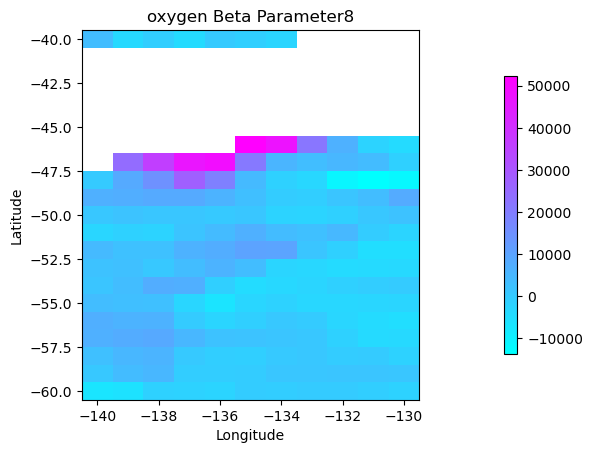

In [7]:
##Betaparams

for i in range(7,8):
    bp = plt.pcolormesh(beta.longitude, beta.latitude, beta.betaparam[:,:,i,0])#, vmin=-200, vmax=200)
    
    cmap = plt.get_cmap('cool')
    plt.set_cmap(cmap)
    plt.title(datafield +' Beta Parameter'+str(i+1))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #plt.xlim(-140,-130)
    #plt.ylim(-60,-40)
    
    cbar = plt.colorbar(bp, shrink=0.75, pad=0.17)
#     plt.savefig(savepath + 'BP_oxy10_'+str(i+1))
    
#     plt.clf()

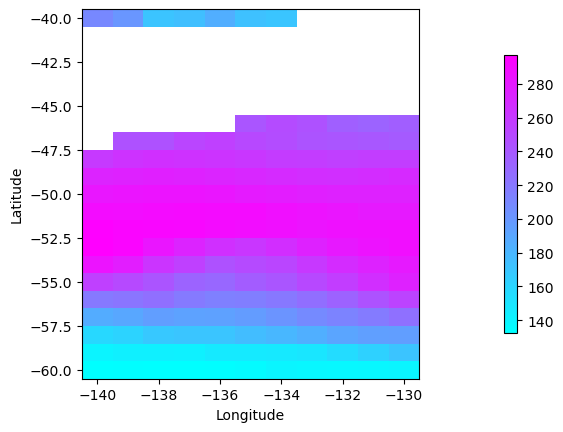

In [8]:
#Finding the constant

bpo6 = beta.betaparam[:,:,5,0]
bpo7 = beta.betaparam[:,:,6,0]
bpo8 = beta.betaparam[:,:,7,0]

bpt = bpts.betaparam_temp[:,:,5,0]
bps = bpts.betaparam_sal[:,:,5,0]

ts = np.add(np.multiply(bpo6,bpt), np.multiply(bpo7,bps))
o2 = np.add(ts, bpo8)

bp = plt.pcolormesh(beta.longitude, beta.latitude, o2)
cmap = plt.get_cmap('cool')
plt.set_cmap(cmap)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar(bp, shrink=0.75, pad=0.17)

plt.savefig(savepath + 'synth_oxy_bp_250db_2015_2017.png')

<h2> Data Points </h2>

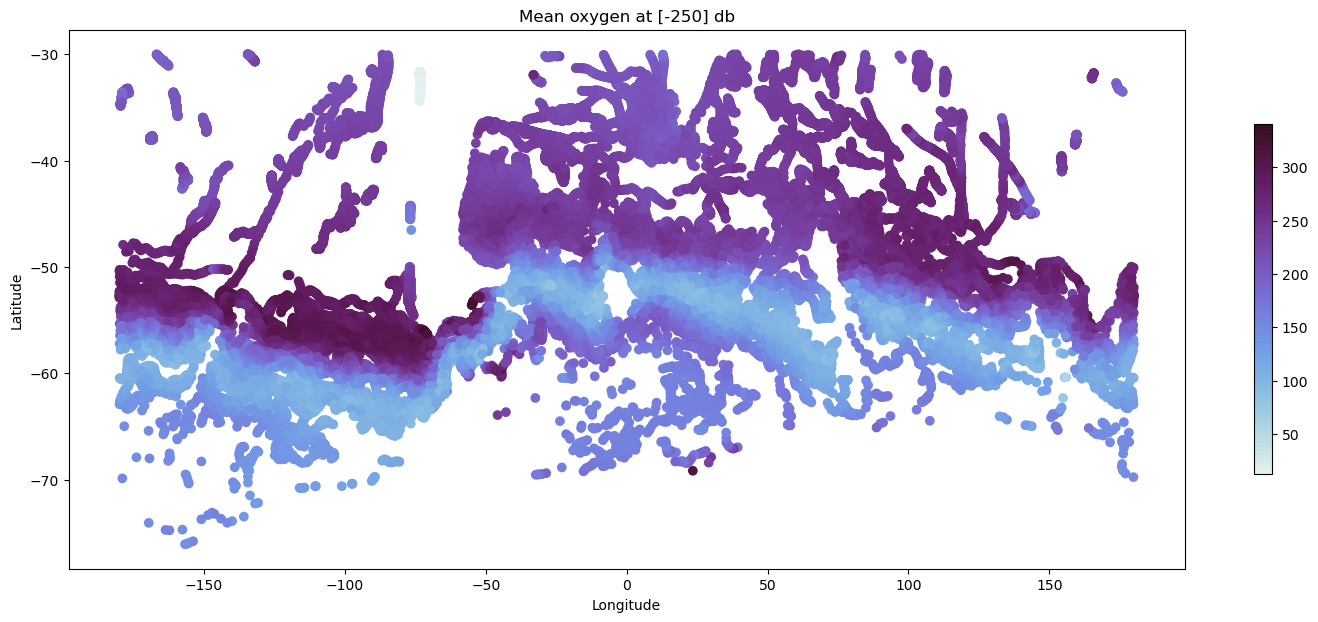

In [18]:
#scatter plot of the mean
fig = plt.figure(figsize=(18,7))
Mean = plt.scatter(res.longitude,res.latitude,c=res.mean_bgc, cmap = cmocean.cm.dense)#, vmin = -50, vmax = 50)
plt.title('Mean ' + datafield + ' at ' + str(res.pressure.values) + ' db')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.xlim(-140,-130)
# plt.ylim(-60,-40)

cbar = plt.colorbar(Mean, shrink = 0.65)

#plt.savefig(savepath + 'synth_mean_oxy_250db_2015_2017.png')

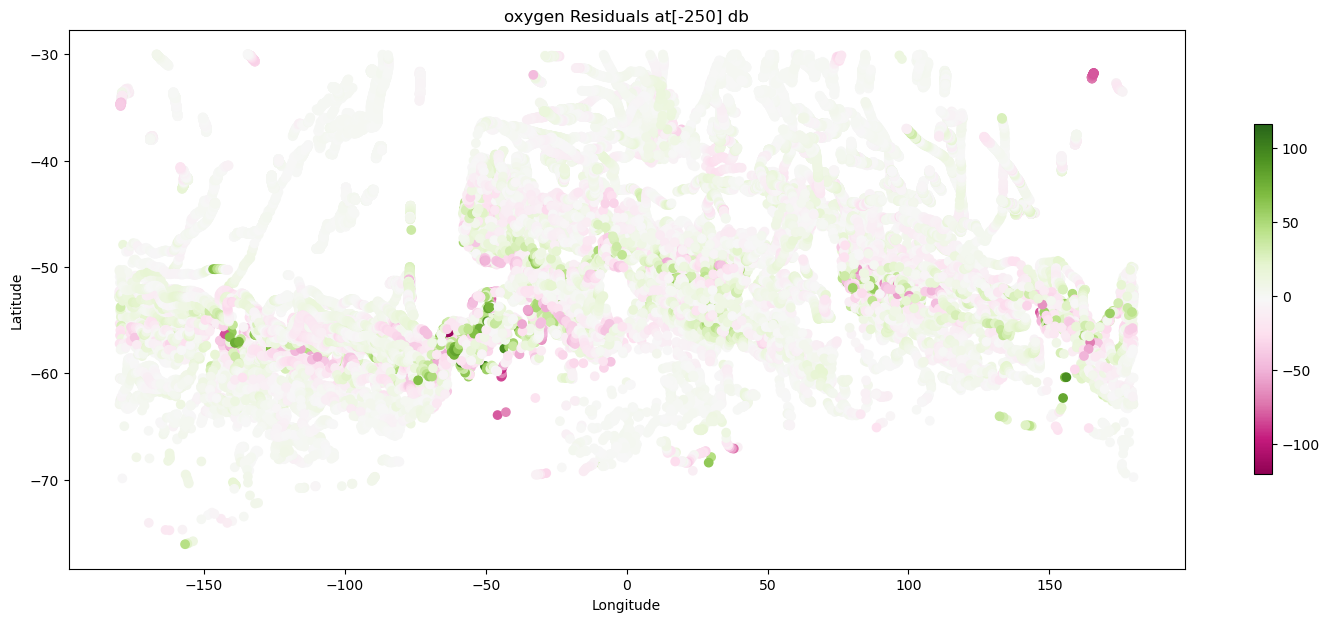

In [17]:
#scatter plot of the residuals
fig = plt.figure(figsize=(18,7))
Mean = plt.scatter(res.longitude,res.latitude,c=res.residuals_bgc, cmap = 'PiYG')#, vmin = -80, vmax = 80)
plt.title(datafield +' Residuals at' + str(res.pressure.values) + ' db')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.xlim(-140,-130)
# plt.ylim(-60,-40)

cbar = plt.colorbar(Mean, shrink = 0.65)

#plt.savefig(savepath + 'synth_oxy_anom_250db_2015_2017.png')

<h2> Gridded Plots </h2>

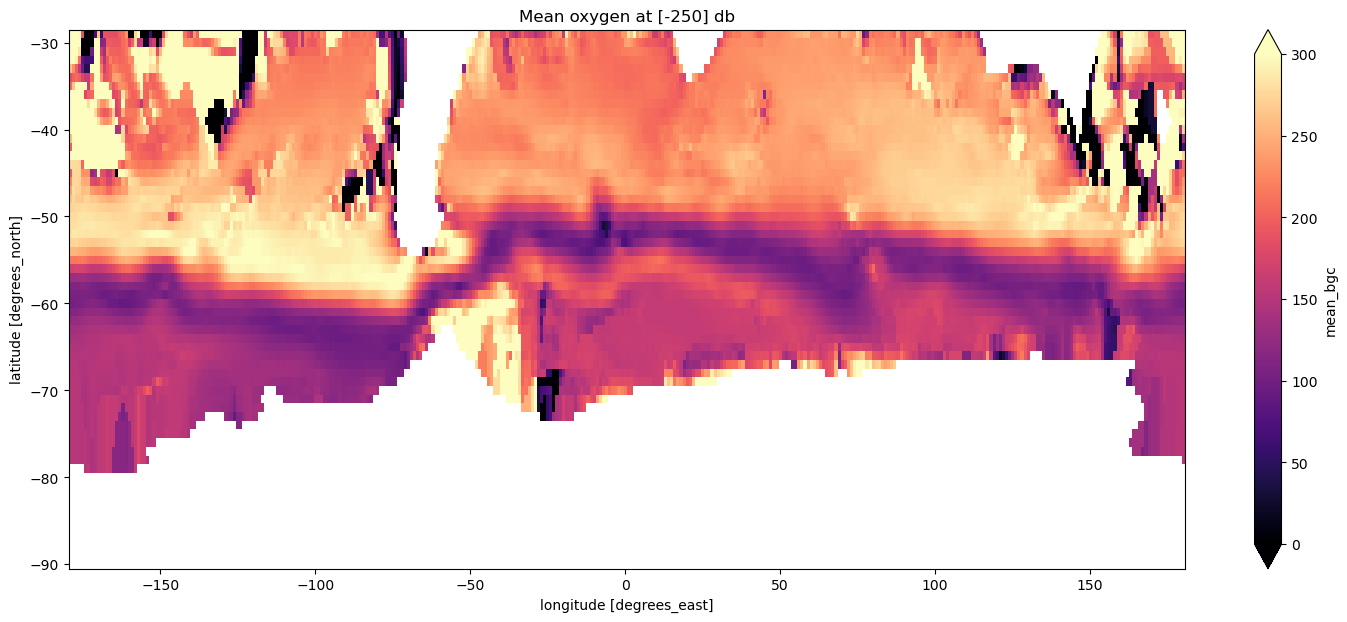

In [16]:
#Gridded Mean
fig = plt.figure(figsize=(18,7))
gs.mean_bgc.sel(latitude=slice(None, -20)).mean('time').plot(cmap='magma', vmin = 0, vmax = 300)
plt.title('Mean ' + datafield + ' at ' + str(gs.pressure.values) +' db')
plt.savefig(savepath + 'largescale_oxygen_250db_final.png')

<h2> Histograms </h2>

Text(0.5, 1.0, 'Mean dissolved_oxygenat [500] db')

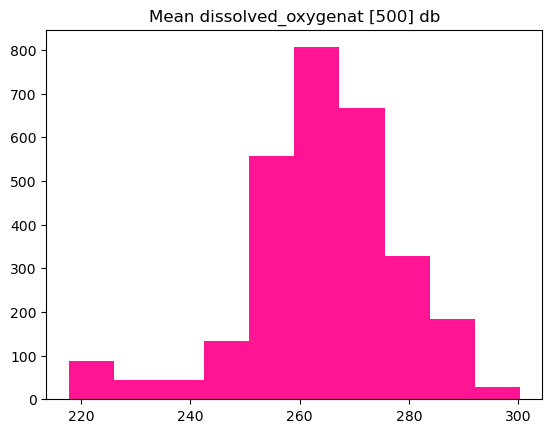

In [18]:
plt.hist(res.mean_bgc, color='deeppink')
plt.title('Mean ' + datafield + 'at ' + str(res.pressure.values)+ ' db')
#plt.savefig(savepath + 'oxy_mean_histogram_700db.png')

Text(0.5, 1.0, 'dissolved_oxygen Residuals at [500] db')

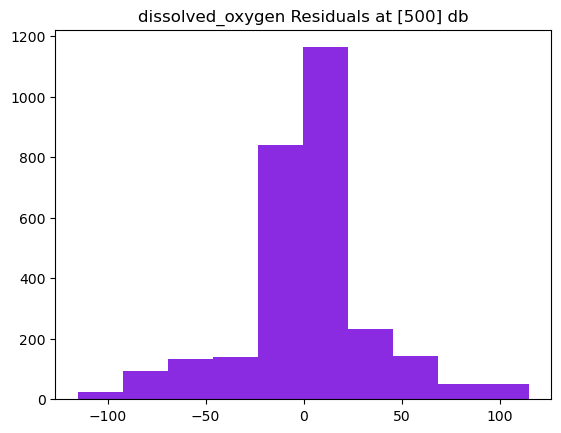

In [19]:
plt.hist(res.residuals_bgc, color='blueviolet')
plt.title( datafield + ' Residuals at ' + str(res.pressure.values)+ ' db')

#plt.savefig(savepath + 'oxy_anom_histogram_700db.png')

In [4]:
res

<xarray.Dataset>
Dimensions:        (i: 2877, pressure: 1)
Coordinates:
    time           (i) datetime64[ns] ...
    latitude       (i) float64 ...
    longitude      (i) float64 ...
  * pressure       (pressure) int64 500
Dimensions without coordinates: i
Data variables:
    mean_bgc       (i, pressure) float64 ...
    residuals_bgc  (i, pressure) float64 ...
Attributes:
    description:          Estimated meandissolved_oxygen, and residuals by su...
    pressureindex:        13
    number_of_harmonics:  2
    window_size:          500000.0
    filename:             /global/homes/k/kefalc/code/anom_files/test/residua...
    created_date:         2024-11-26 20:05:04.747904

In [42]:
res2 = res.where(np.isnan(res.residuals_bgc)==True, drop=True)
res2

<xarray.Dataset>
Dimensions:        (i: 5, pressure: 1)
Coordinates:
    time           (i) datetime64[ns] 2013-12-17T09:49:33.001036544 ... 2018-...
    latitude       (i) float64 -57.52 -53.71 -54.02 -54.41 -54.65
    longitude      (i) float64 -140.8 -146.3 -138.5 -128.9 -123.1
  * pressure       (pressure) int64 500
Dimensions without coordinates: i
Data variables:
    mean_bgc       (i, pressure) float64 254.4 275.7 273.1 263.0 258.5
    residuals_bgc  (i, pressure) float64 nan nan nan nan nan
Attributes:
    description:          Estimated meandissolved_oxygen, and residuals by su...
    pressureindex:        13
    number_of_harmonics:  2
    window_size:          500000.0
    filename:             /global/homes/k/kefalc/code/anom_files/test/residua...
    created_date:         2024-11-26 20:05:04.747904

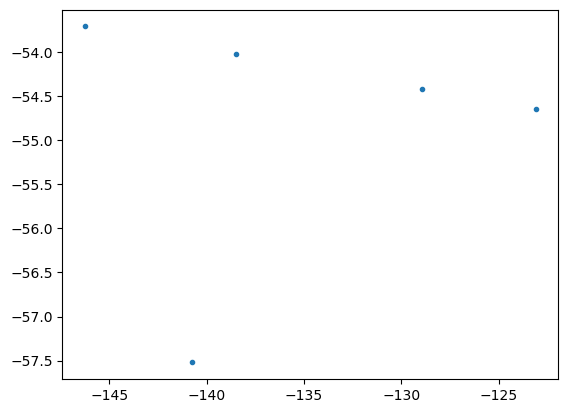

In [43]:
plt.plot(res2.longitude, res2.latitude, '.')
#plt.scatter(res2.longitude, res2.latitude, c=res.residuals_bgc)

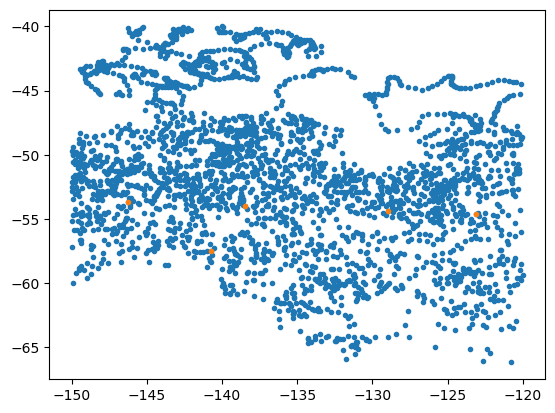

In [45]:
plt.plot(res.longitude, res.latitude, '.')
plt.plot(res2.longitude, res2.latitude, '.')

In [53]:
bgcdatafile = '/global/u2/k/kefalc/code/data_files/SO_ts_for_bgc.nc'
bgc = xr.open_dataset(bgcdatafile)
bgc2 = bgc.isel(pressure =13)
bgc2

<xarray.Dataset>
Dimensions:           (profile: 2877)
Coordinates:
    lon               (profile) float64 ...
    lat               (profile) float64 ...
    time              (profile) float64 ...
  * profile           (profile) float64 8.766e+03 8.767e+03 ... 6.084e+03
    WMOID             (profile) float64 ...
    pressure          int64 500
Data variables:
    temperature       (profile) float64 ...
    salinity          (profile) float64 ...
    dissolved_oxygen  (profile) float64 ...

In [61]:
bgc4 = bgc.where(bgc.dissolved_oxygen < 0, drop = True)
bgc4

<xarray.Dataset>
Dimensions:           (pressure: 29, profile: 24)
Coordinates:
    lon               (profile) float64 -148.9 -146.2 -144.2 ... -121.6 -120.9
    lat               (profile) float64 -54.15 -53.4 -54.21 ... -52.24 -51.78
    time              (profile) float64 1.612e+18 1.613e+18 ... 1.633e+18
  * profile           (profile) float64 4.162e+03 4.163e+03 ... 4.185e+03
    WMOID             (profile) float64 6.904e+06 6.904e+06 ... 6.904e+06
  * pressure          (pressure) int64 5 10 20 30 50 ... 1700 1800 1900 2000
Data variables:
    temperature       (pressure, profile) float64 2.037 2.147 ... 5.611 nan
    salinity          (pressure, profile) float64 33.96 34.11 ... 34.69 nan
    dissolved_oxygen  (pressure, profile) float64 -219.7 -219.8 ... -202.9 nan

In [64]:
bgc4.WMOID

<xarray.DataArray 'WMOID' (profile: 24)>
array([6903767., 6903767., 6903767., 6903767., 6903767., 6903767.,
       6903767., 6903767., 6903767., 6903767., 6903767., 6903767.,
       6903767., 6903767., 6903767., 6903767., 6903767., 6903767.,
       6903767., 6903767., 6903767., 6903767., 6903767., 6903767.])
Coordinates:
    lon      (profile) float64 -148.9 -146.2 -144.2 ... -121.4 -121.6 -120.9
    lat      (profile) float64 -54.15 -53.4 -54.21 ... -52.87 -52.24 -51.78
    time     (profile) float64 1.612e+18 1.613e+18 ... 1.632e+18 1.633e+18
  * profile  (profile) float64 4.162e+03 4.163e+03 ... 4.184e+03 4.185e+03
    WMOID    (profile) float64 6.904e+06 6.904e+06 ... 6.904e+06 6.904e+06

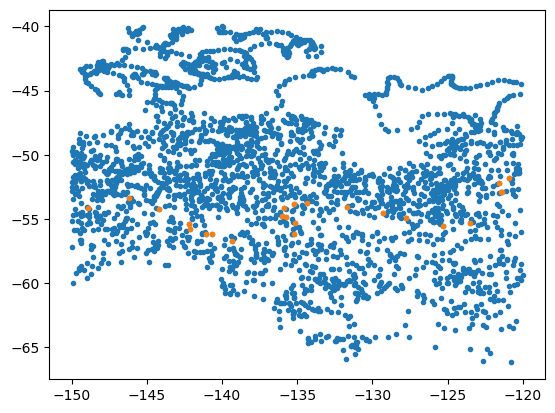

In [63]:
plt.plot(bgc.lon, bgc.lat, '.')
plt.plot(bgc4.lon, bgc4.lat, '.')


In [55]:
bgc3 = bgc2.where(np.isnan(bgc2.dissolved_oxygen)==True, drop=True)
bgc3

<xarray.Dataset>
Dimensions:           (profile: 5)
Coordinates:
    lon               (profile) float64 -140.8 -146.3 -138.5 -128.9 -123.1
    lat               (profile) float64 -57.52 -53.71 -54.02 -54.41 -54.65
    time              (profile) float64 1.387e+18 1.513e+18 ... 1.523e+18
  * profile           (profile) float64 334.0 1.05e+04 ... 1.05e+04 1.051e+04
    WMOID             (profile) float64 5.904e+06 6.903e+06 ... 6.903e+06
    pressure          int64 500
Data variables:
    temperature       (profile) float64 2.107 nan nan nan nan
    salinity          (profile) float64 nan nan nan nan nan
    dissolved_oxygen  (profile) float64 nan nan nan nan nan

/global/homes/k/kefalc/.conda/envs/myenv/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:871: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  self.set_xlim([x1, x2])


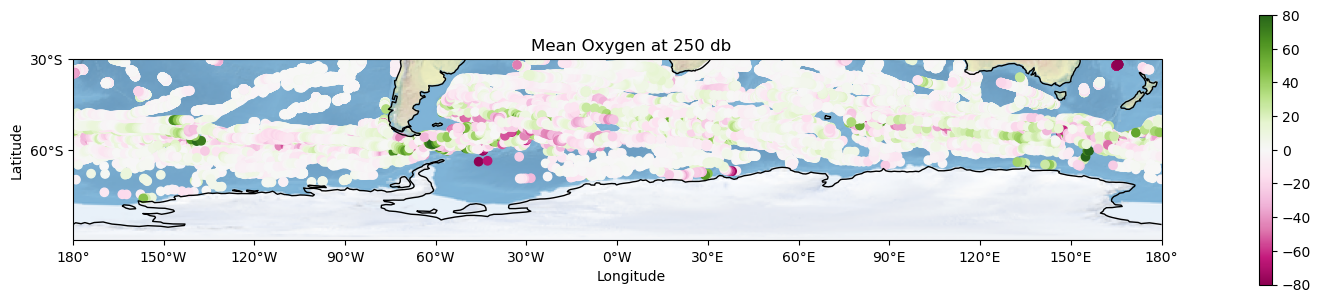

In [34]:
fig = plt.figure(figsize=(18,7)) # x, y
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.set_extent([-180, 180, -90, -30])
fig = plt.scatter(res.longitude,res.latitude,c=res.residuals_bgc, cmap = 'PiYG', vmin = -80, vmax = 80)
# for nn in tqdm(range(0,data_to_save_lonb.shape[0])):
#     plt.plot(data_to_save_lonb[nn], data_to_save_latb[nn],
#                  color=color1, marker='o',markersize=ms,transform=ccrs.Geodetic())
ax.yaxis.tick_left()

ax.set_xticks([-180,-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180],crs=ccrs.PlateCarree())
ax.set_yticks([-60, -30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

cbar = plt.colorbar(fig, shrink = 0.5)
plt.title('Mean Oxygen at 250 db')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.savefig(savepath + 'largescale_res_oxygen_250db_final.png')

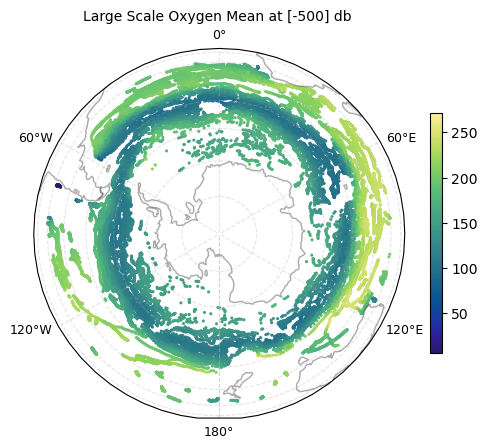

In [14]:
ds = xr.open_dataset('/global/homes/k/kefalc/code/anom_files/final/oxy/res/residualfile_plevel4oxygen_dates16436.0_18261.0_test0.nc')
#plt.figure(figsize=(16,12))

projection = ccrs.NearsidePerspective(central_latitude=-90)
data_crs = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
#ax.stock_img() #this fills in background with map image (blue water, white ice etc.)
ax.coastlines(alpha=0.3333)
gl = ax.gridlines(draw_labels=True,alpha=0.33, linestyle='--')
#ax.set_extent([-140,-130,-90, -30])
gl.xlabel_style = {'size': 9}
# gl.ylabel_style = {'size': 7}
temp = ax.scatter(ds.longitude,ds.latitude, s=5, c=ds.mean_bgc, cmap=cmocean.cm.haline, linewidths=0,transform = data_crs)#, vmin = -50, vmax = 50)
axs = plt.gca()
cbar = plt.colorbar(temp, ax=axs, shrink=0.65)

#haline for oxy, matter for temp, solar for salinity
#curl for diverging plots
plt.title('Large Scale Oxygen Mean at ' + str(ds.pressure.values)+ ' db ', fontsize=10)
plt.show()
#plt.savefig(savepath + 'Test_Salinity_Mean_250db_Map.png')